In [17]:
import os
import pandas as pd
from policies.mappo import MAPPO
from environment.optimization_environment import OptimizationEnv
from environment.utils import parse_config
from datetime import datetime
import numpy as np
import seaborn as sns
import os
import neptune
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy
from other_algorithms.pso import ParticleSwarmOptimizer
import time
from scipy.stats import multivariate_normal
from dotenv import load_dotenv
load_dotenv()

True

In [18]:
def initialize(config_path, mode="train", **kwargs):
    env = OptimizationEnv(config_path)
    agent_policy = MAPPO(config_path)
    if mode == "test" or mode == "benchmark":
        model_path = kwargs.get("model_path", None)
        if model_path is None:
            raise ValueError("Model path must be provided for testing")
        agent_policy.load(model_path)
    return env, agent_policy

def print_items(**kwargs):
    for key, value in kwargs.items():
        print(key, value)
        
def get_action(observation_info, agent_policy, env):
    observation, observation_std = observation_info
    actions = np.zeros((env.n_agents, env.n_dim))
    for dim in range(env.n_dim):
        observation[dim] = observation[dim].astype(np.float32)
        #print(observation[dim])
        observation_std[dim] = observation_std[dim].astype(np.float32)
        action = agent_policy.select_action(observation[dim], observation_std[dim])
        actions[:, dim] = action
    return actions

# def cal_densities(points):
#     densities = np.array([multivariate_normal(mean=mean, cov=cov, allow_singular=True).pdf(points)
#                               for mean, cov in zip(env.gmm.gmm.means_, env.gmm.gmm.covariances_)])
#     return densities

# def cal_densities_variances(densities):
#     variances = []
#     for dim in range(densities.shape[0]):
#         densities_variances = np.var(densities[dim], axis=0)
#         print(densities_variances)
#         variances.append(densities_variances)
#     return variances

In [24]:
config_path = 'config/config.json'
model_path = "models/exploiting_model.pth"
mode = "test"
env, agent_policy = initialize(config_path, mode=mode, model_path=model_path)
config = parse_config(config_path)
agent_policy.set_action_std(config["test_action_std"])

def display_gmm_details(gmm):
    print("Means: ", gmm.means_)
    print("Covariances: ", gmm.covariances_)
    print("Weights: ", gmm.weights_)


Loaded policy from:  models/exploiting_model.pth


In [4]:
_ = env.reset()

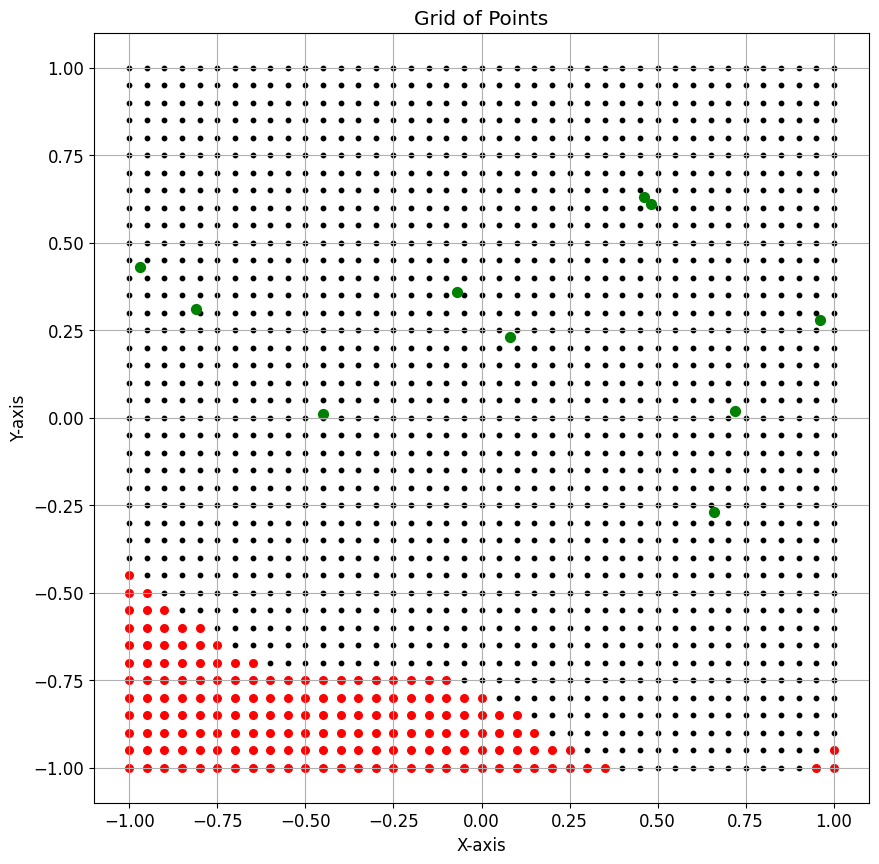

In [5]:
env.surrogate.plot_checkpoints_state()

In [6]:
def get_informed_action(env):
    # let the action be the distance it takes for the agents to get to the a random point in the high std points
    actions = np.zeros((env.n_agents, env.n_dim))
    high_std_points, high_std_points_std = env._get_unexplored_area()
    taken_points_index = []
    for agents in range(env.n_agents):
        while True:
            index = np.random.randint(0, high_std_points.shape[0])
            if index not in taken_points_index:
                taken_points_index.append(index)
                break
        agent_target = high_std_points[index]
        # get the difference between the agent's current position and the target
        diff = agent_target - env.state[agents][:env.n_dim]
        actions[agents] = diff
    return actions
        
        

In [7]:
get_informed_action(env)

array([[ 0.06 , -0.615],
       [-0.095, -0.455],
       [-0.86 , -0.26 ],
       [-0.18 , -0.365],
       [-0.68 , -0.74 ],
       [-0.215, -0.78 ],
       [-0.1  , -0.455],
       [-0.515, -0.515],
       [-0.405, -0.64 ],
       [-0.39 , -0.505]])

# VARIANCE DRIVEN EXPLORERS

Iteration:  0
current step: 0


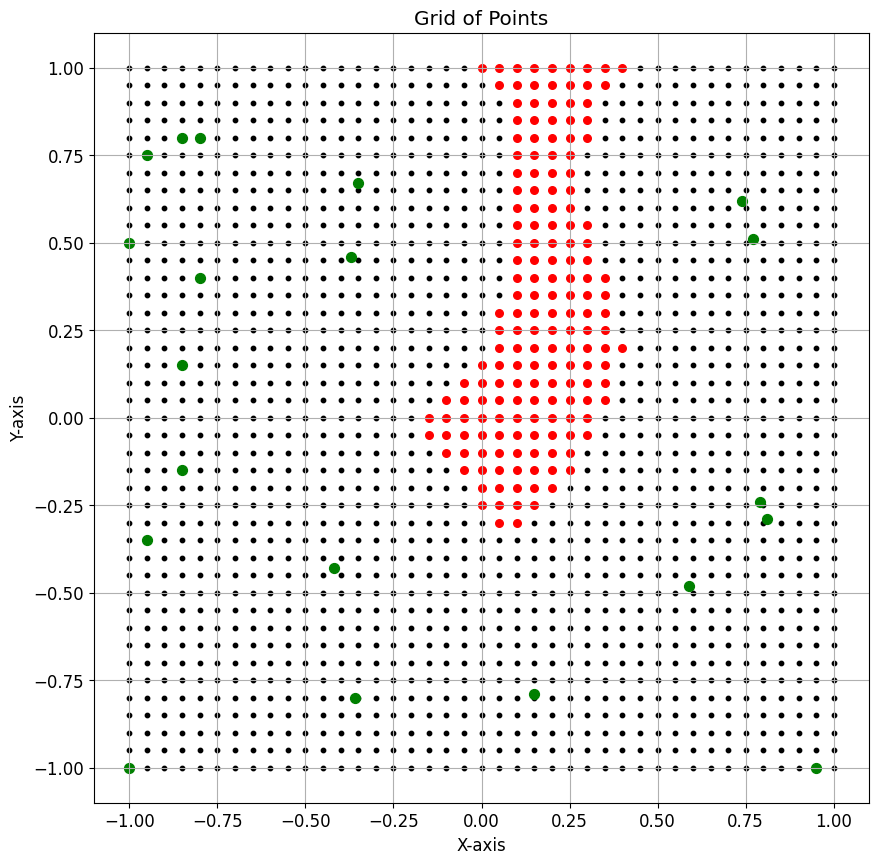

Iteration:  1
current step: 1


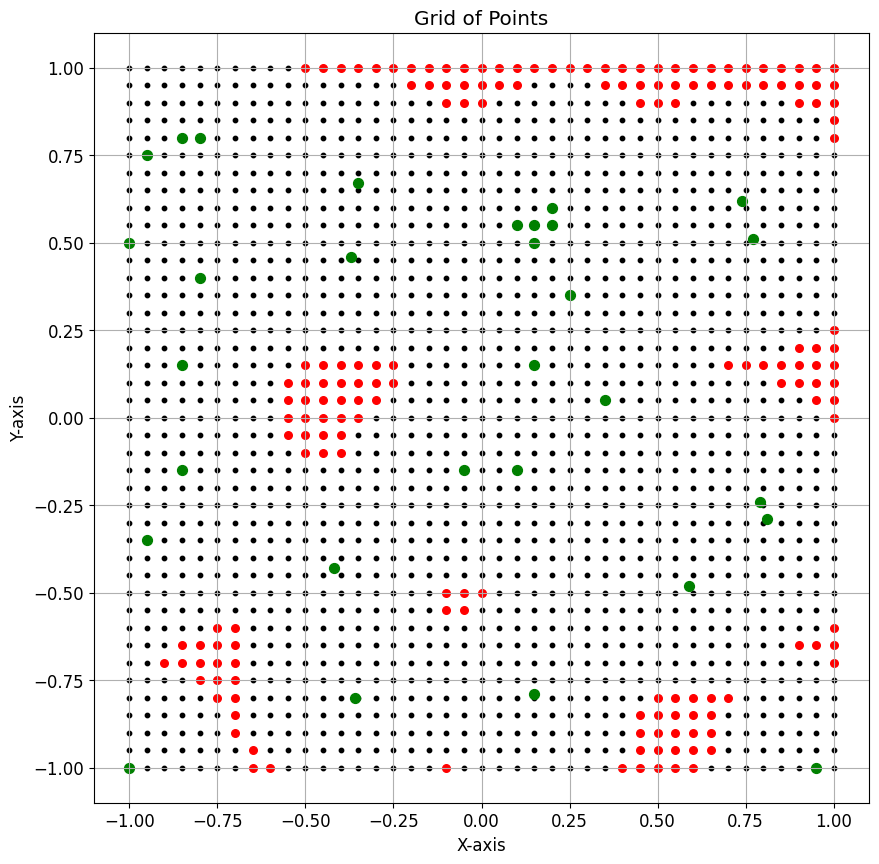

Iteration:  2
current step: 2


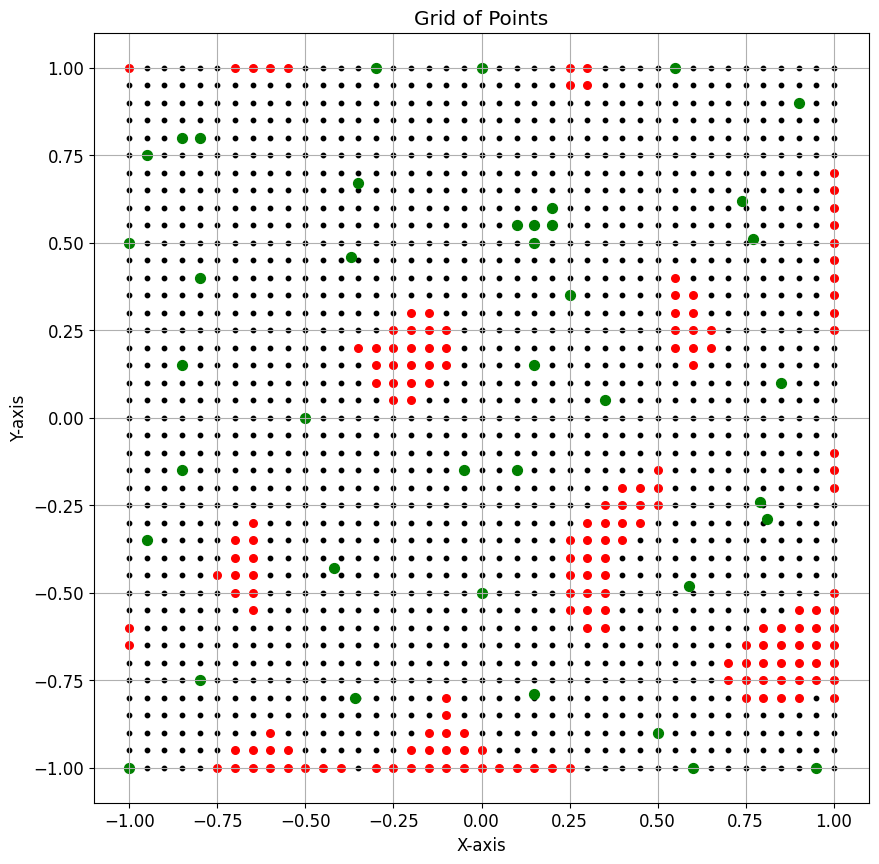

Iteration:  3
current step: 3


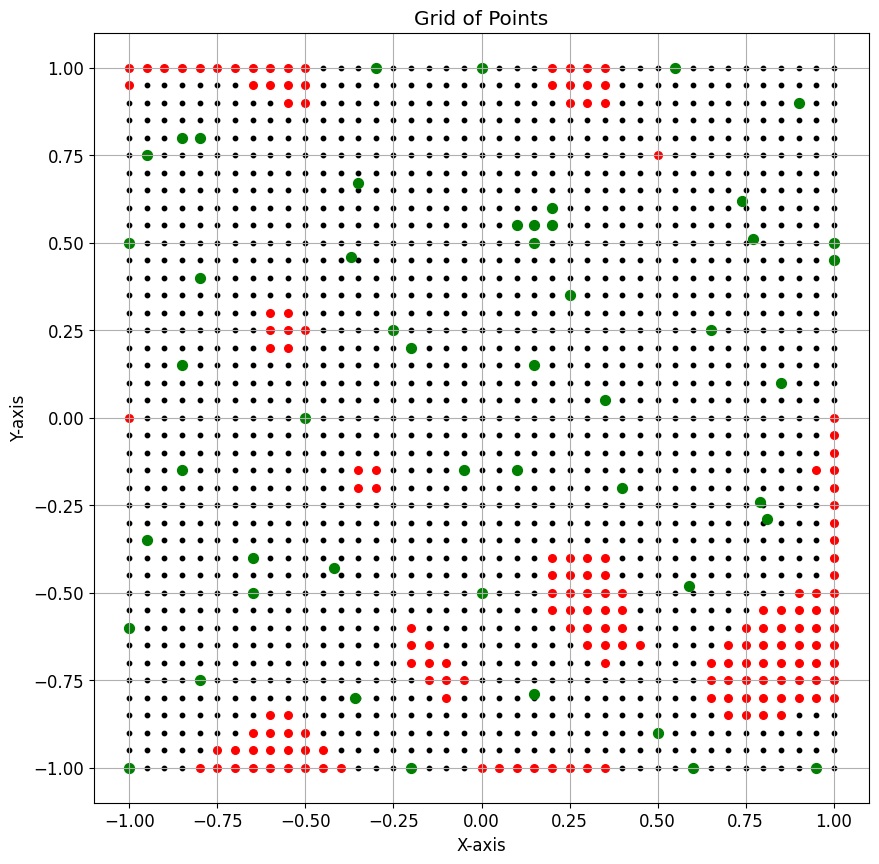

Iteration:  4
current step: 4


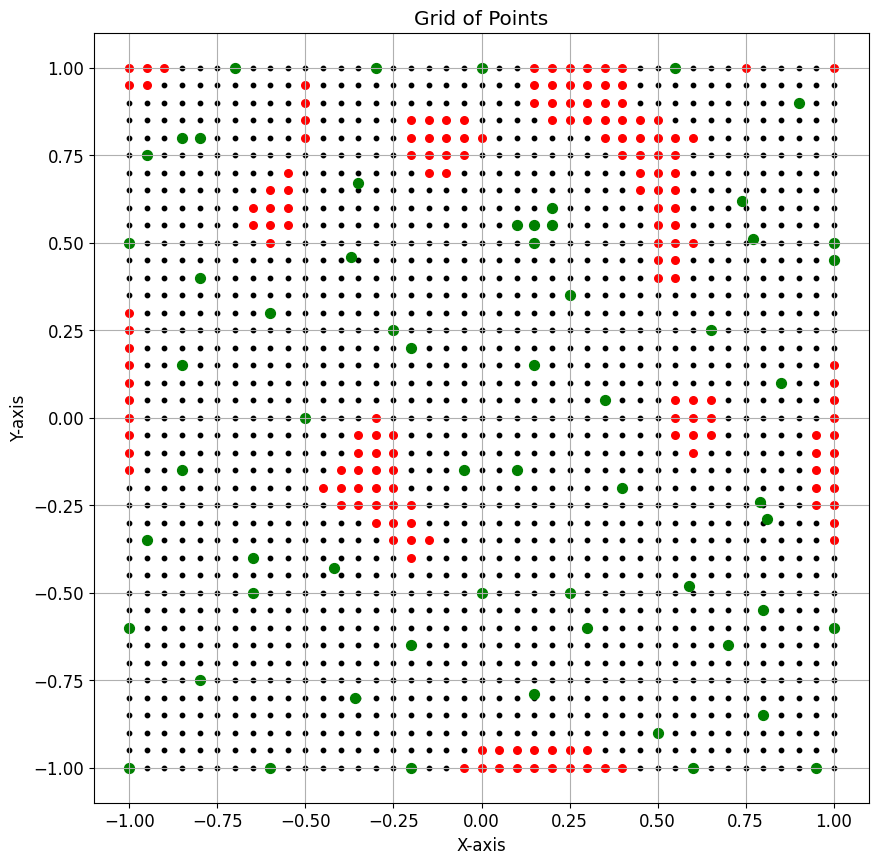

Iteration:  5
current step: 5


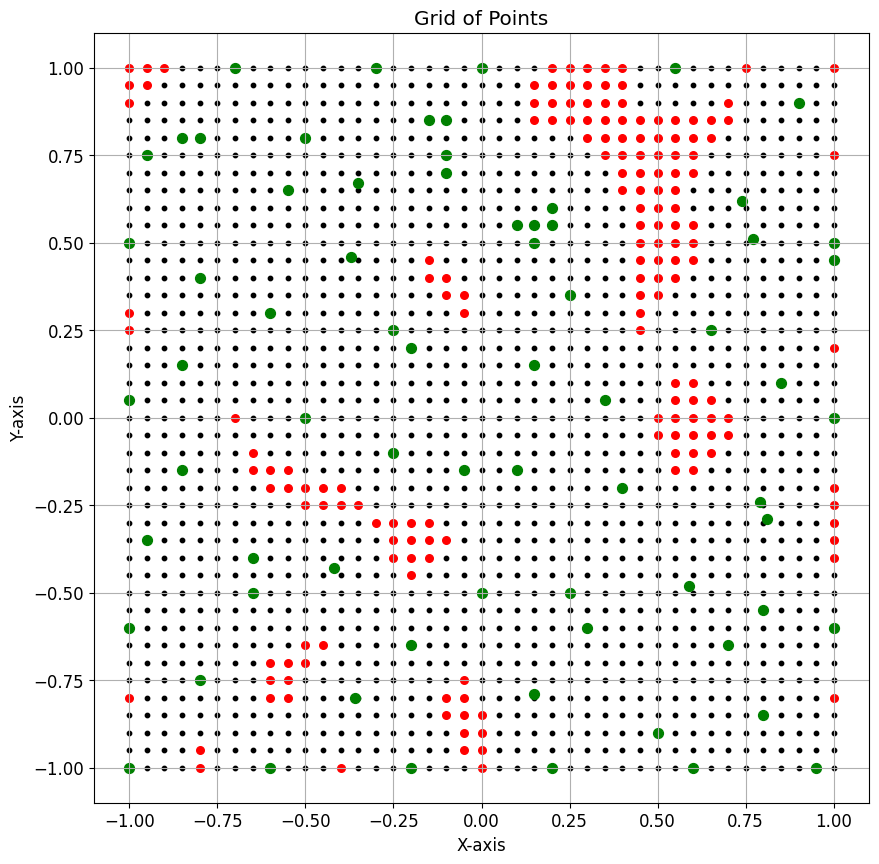

Iteration:  6
current step: 6


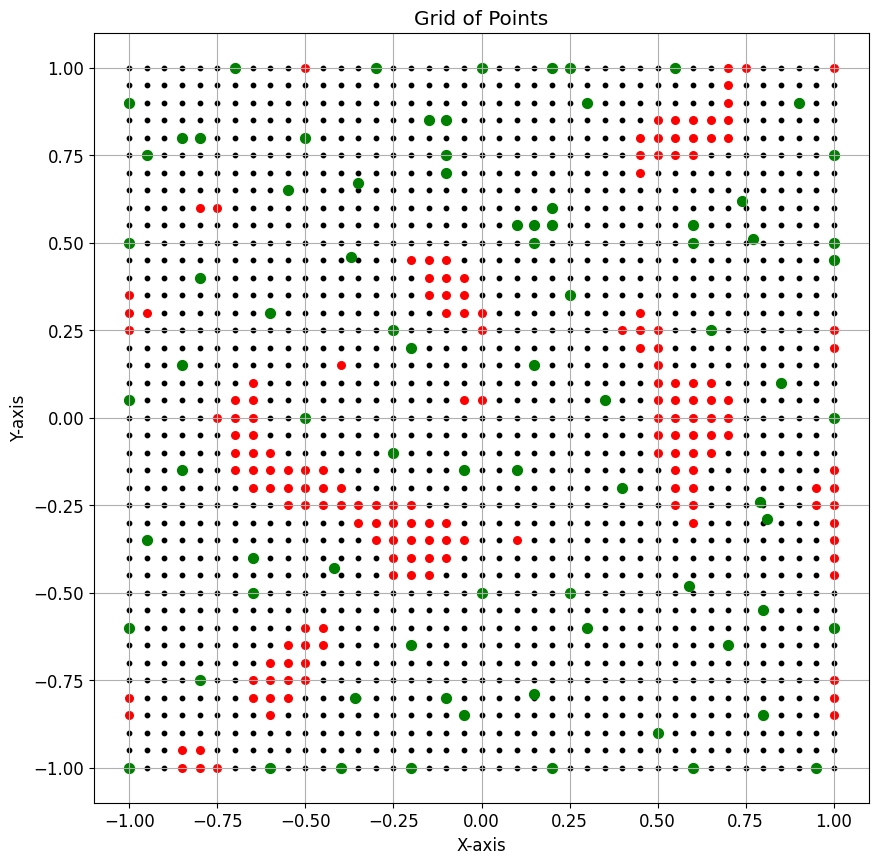

Iteration:  7
current step: 7


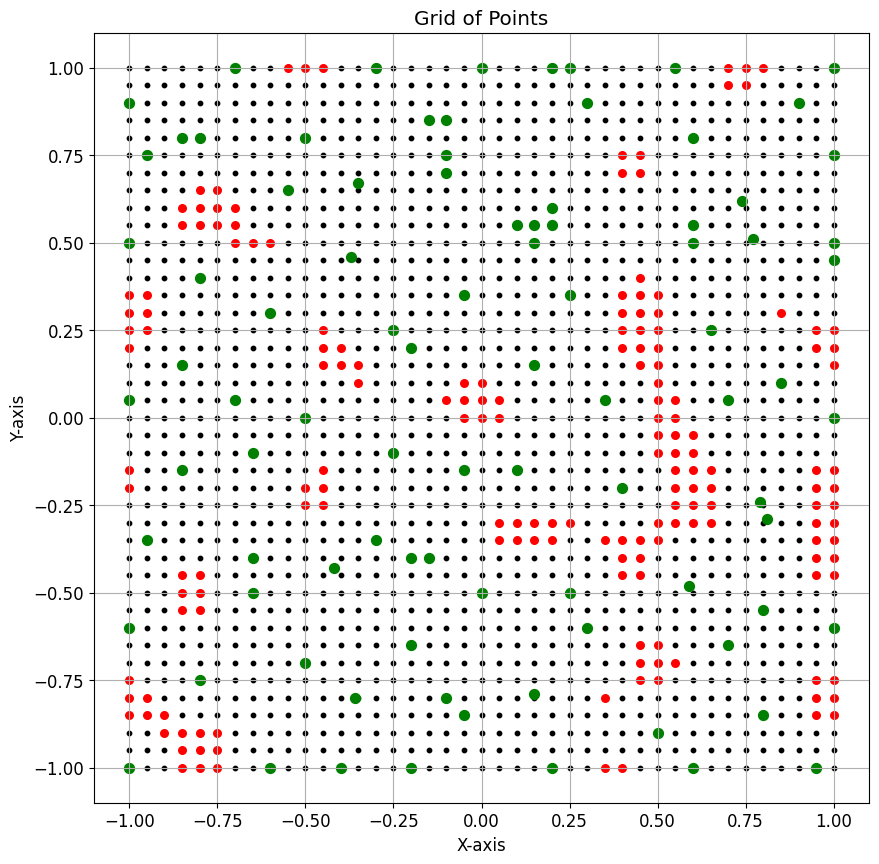

Iteration:  8
current step: 8


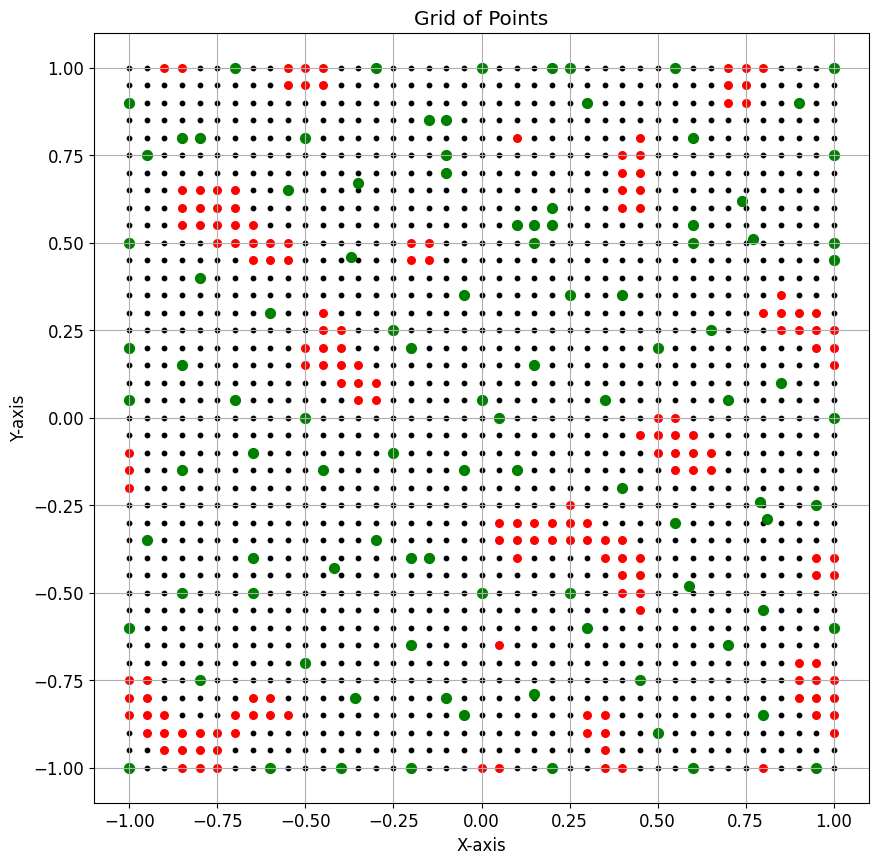

Iteration:  9
current step: 9


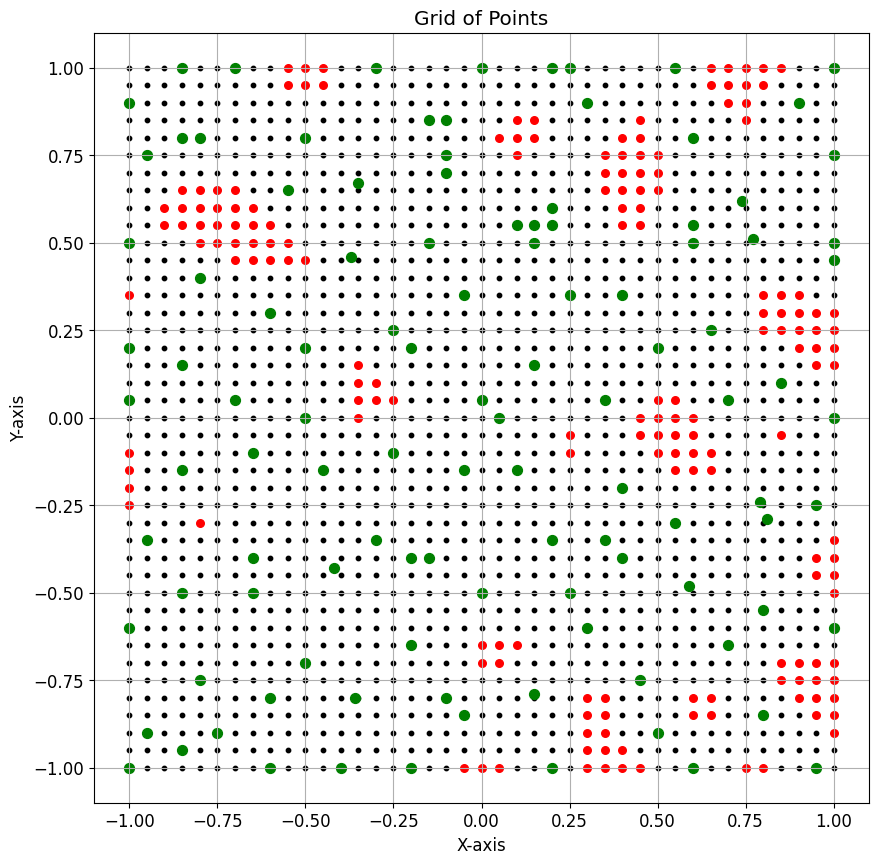

Iteration:  10
current step: 10


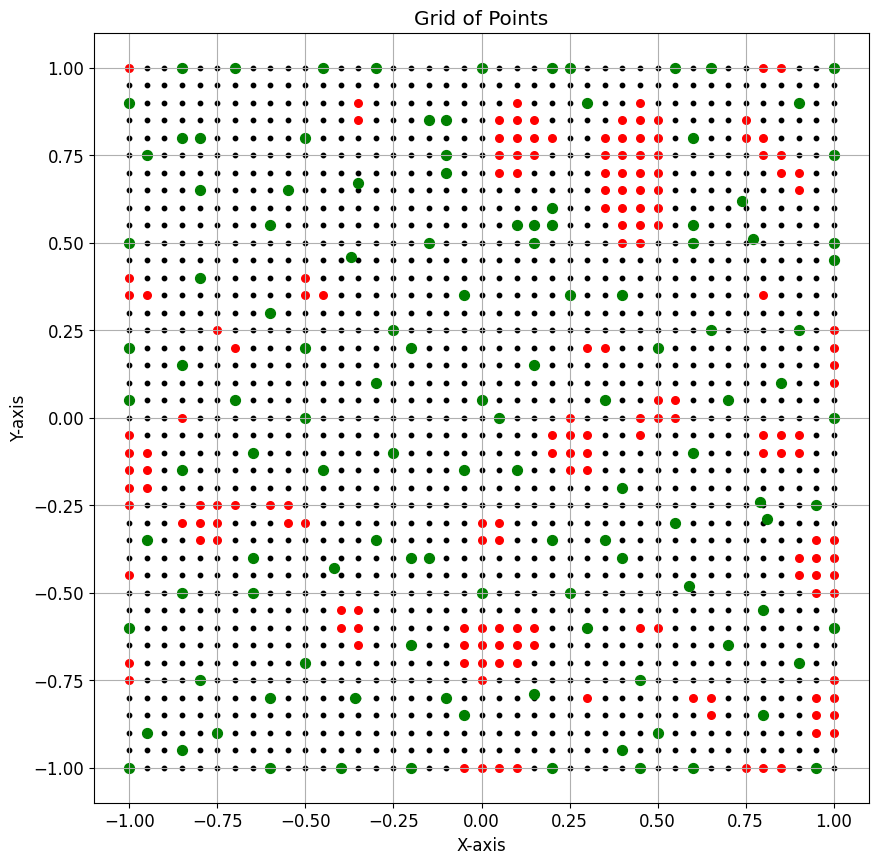

In [8]:
observation_info = env.reset()
rewards = []
std_comp = []
hig_std_comp = []
iters = 11
results_buffer = np.zeros((iters, 4))


for i in range(iters):
    print("Iteration: ", i)
    #action =  get_action(observation_info, agent_policy, env)
    action = get_informed_action(env)
    observation_info, reward, done, info = env.step(action)
    rewards.append(np.mean(reward)) 
    env.surrogate.plot_checkpoints_state()

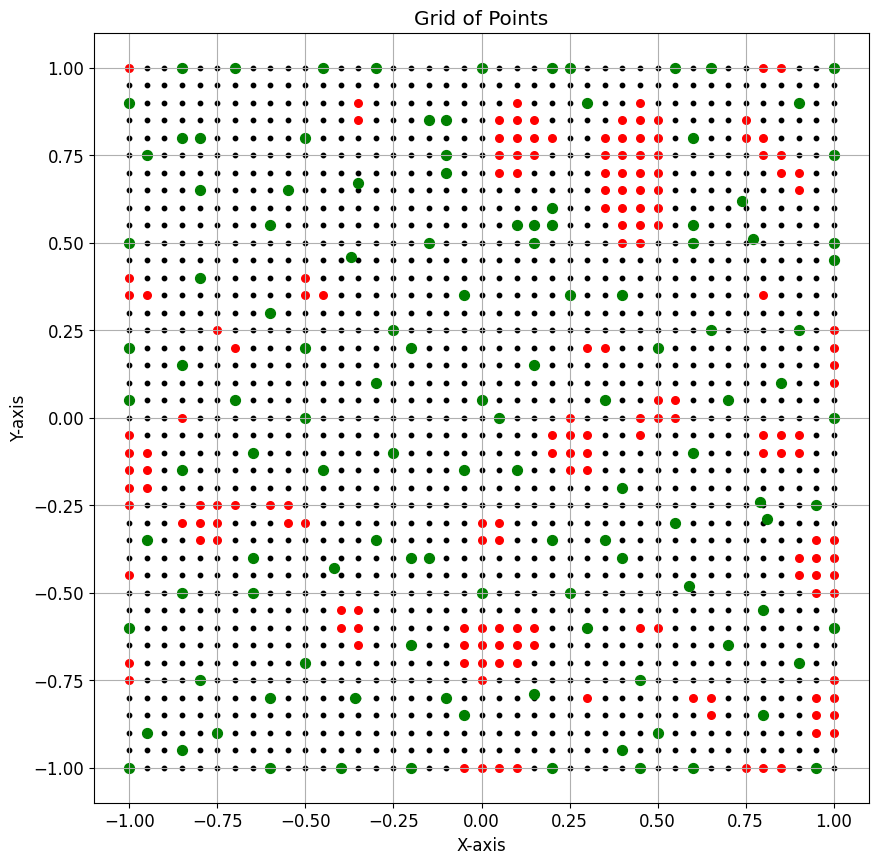

In [9]:
env.surrogate.plot_checkpoints_state()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
MovieWriter Pillow unavailable; using Pillow instead.


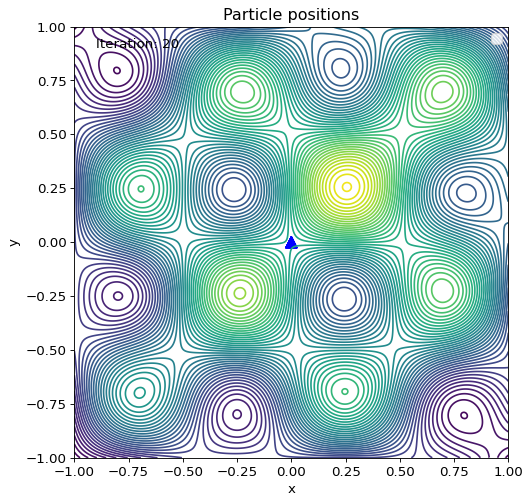

In [10]:
env.render(type="history", file_path="new_history1.gif")

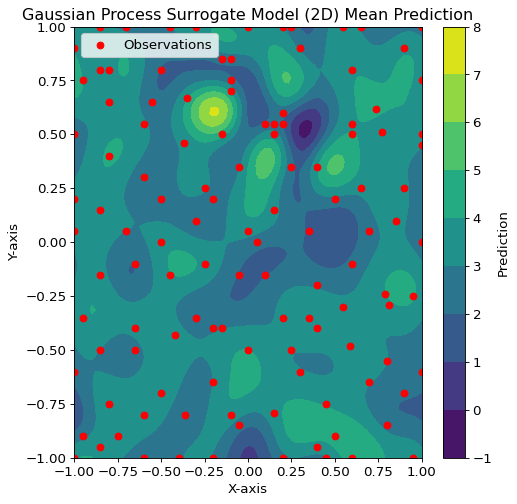

In [11]:
env.surrogate.plot_surrogate()

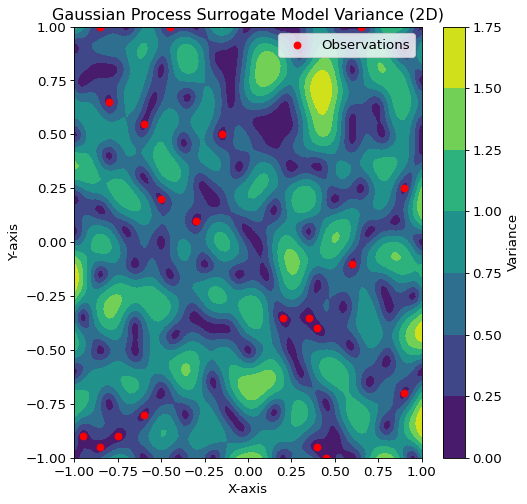

In [12]:
env.surrogate.plot_variance()

# EXPLOITERS

In [25]:
observation_info = env.reset()
rewards = []
std_comp = []
hig_std_comp = []
iters = 11
results_buffer = np.zeros((iters, 4))


for i in range(iters):
    print("Iteration: ", i)
    action =  get_action(observation_info, agent_policy, env)
    #action = get_informed_action(env)
    print(action)
    observation_info, reward, done, info = env.step(action)
    #env.surrogate.plot_checkpoints_state()

Iteration:  0
[[-0.05280602 -0.32420564]
 [ 0.51666123  0.94363123]
 [-0.06965179 -0.02193239]
 [-0.54920149  0.19587934]
 [-0.44339585  0.70789897]
 [ 0.39791834 -0.38578215]
 [ 0.3608014   0.42158628]
 [ 0.10795353  0.62185365]
 [-0.21060641 -0.40280935]
 [-0.01939972 -0.28669819]]
current step: 0
Iteration:  1
[[ 0.00800264  0.19634478]
 [-0.25572097 -0.29884988]
 [ 0.01595495 -0.04831869]
 [ 0.22665466  0.04492019]
 [ 0.11919517 -0.13805859]
 [-0.16942888  0.05493248]
 [ 0.22196017  0.22912513]
 [ 0.03223151 -0.06294451]
 [ 0.15742595  0.20569788]
 [-0.08244124 -0.12539102]]
current step: 1
Iteration:  2
[[ 0.08366762  0.08540511]
 [ 0.11838533 -0.04643096]
 [ 0.07955852  0.00143248]
 [-0.00891494  0.04849847]
 [-0.08353426 -0.11909287]
 [ 0.08797684  0.13745913]
 [-0.17852585 -0.12209675]
 [ 0.01416265 -0.04926741]
 [-0.01036975 -0.01776538]
 [ 0.09159406  0.1234916 ]]
current step: 2
Iteration:  3
[[ 0.02071376 -0.0665657 ]
 [-0.01085076  0.01735453]
 [-0.05598366 -0.08123018]
 [

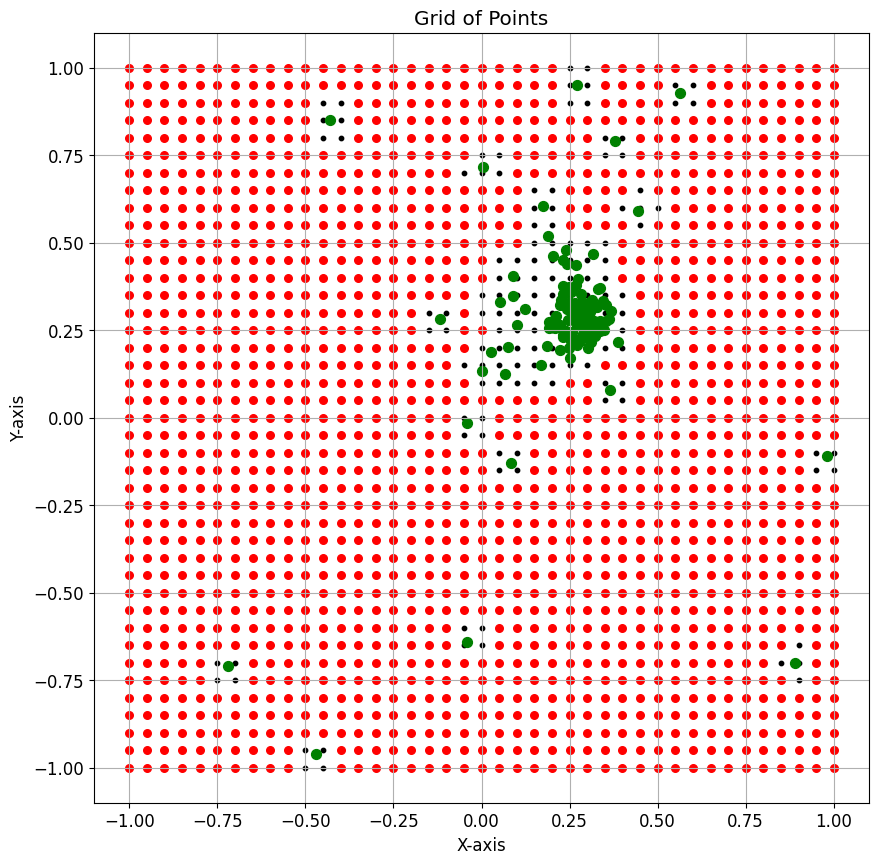

In [26]:
env.surrogate.plot_checkpoints_state()

# COMBINING EXPLORERS AND EXPLOITERS

Iteration:  0
current step: 0


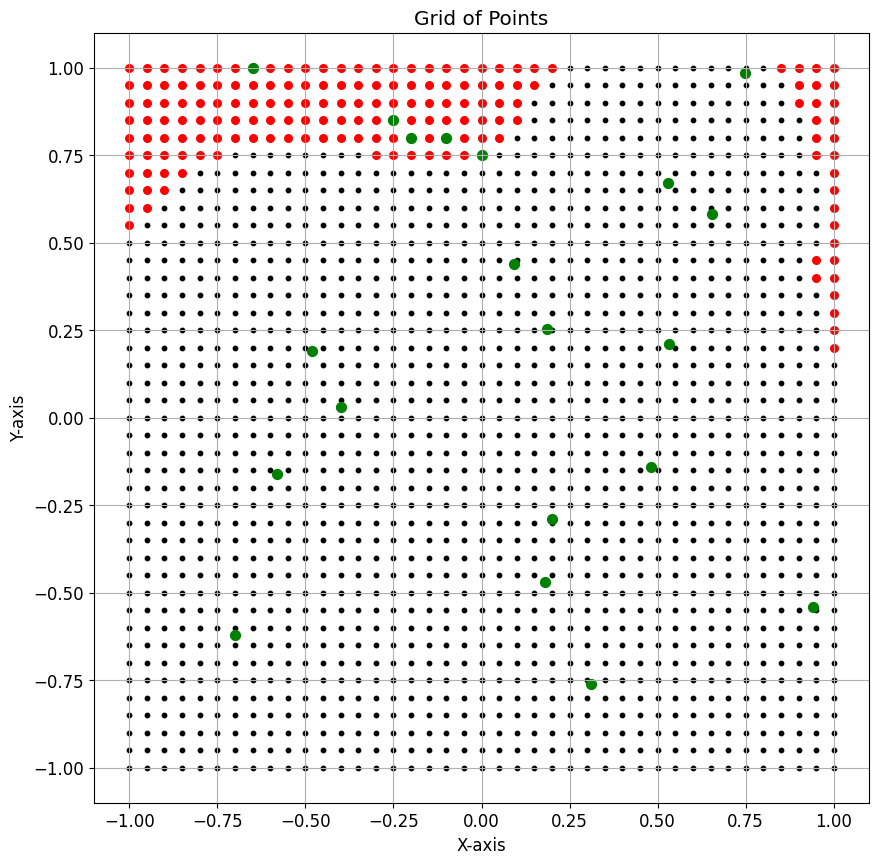

Iteration:  1
current step: 1


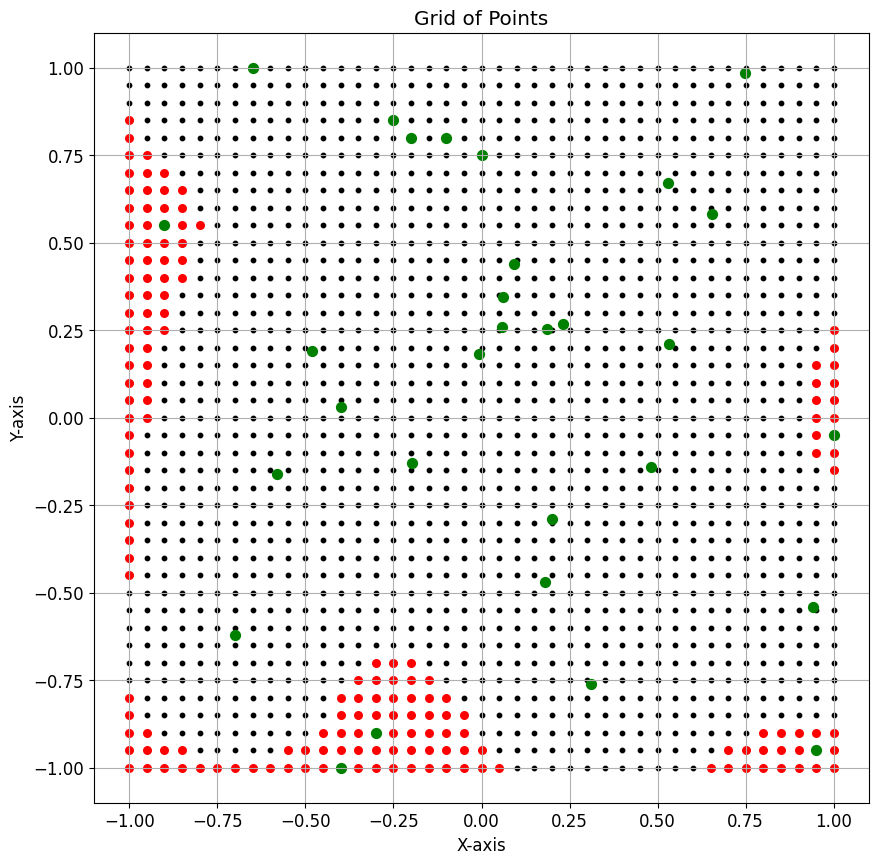

Iteration:  2
current step: 2


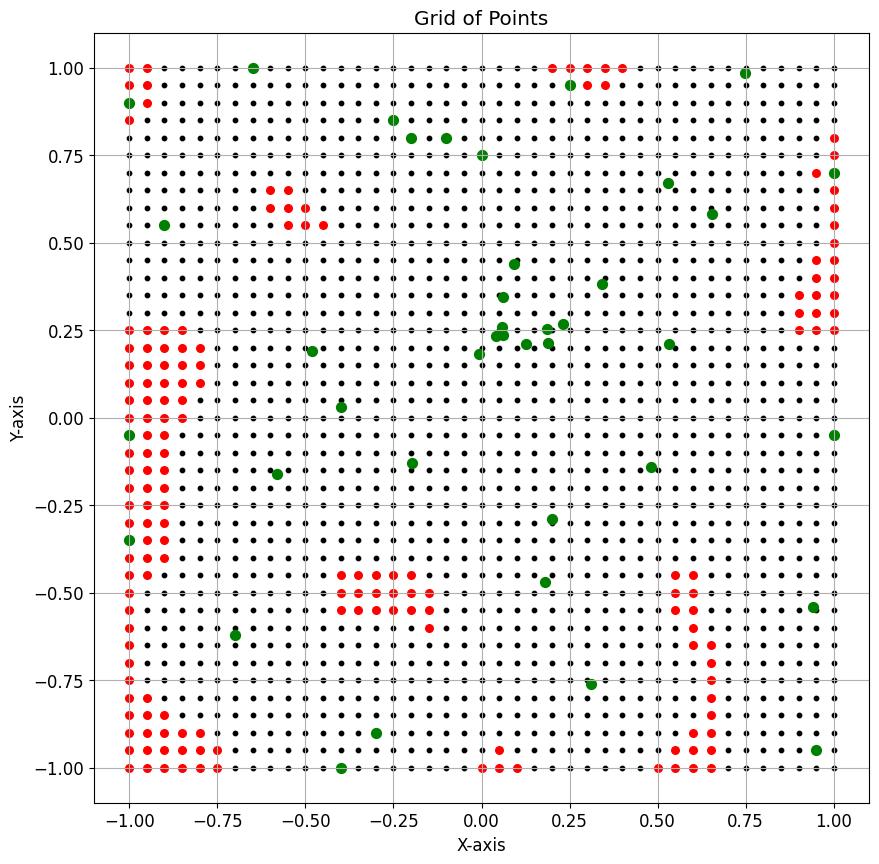

Iteration:  3
current step: 3


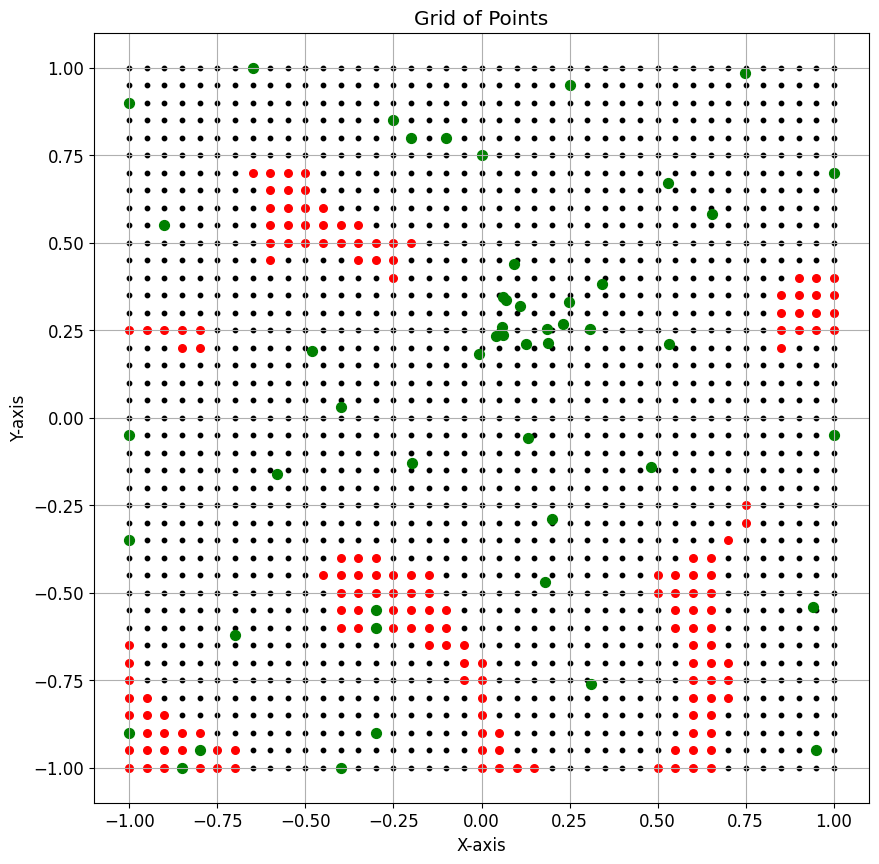

Iteration:  4
current step: 4


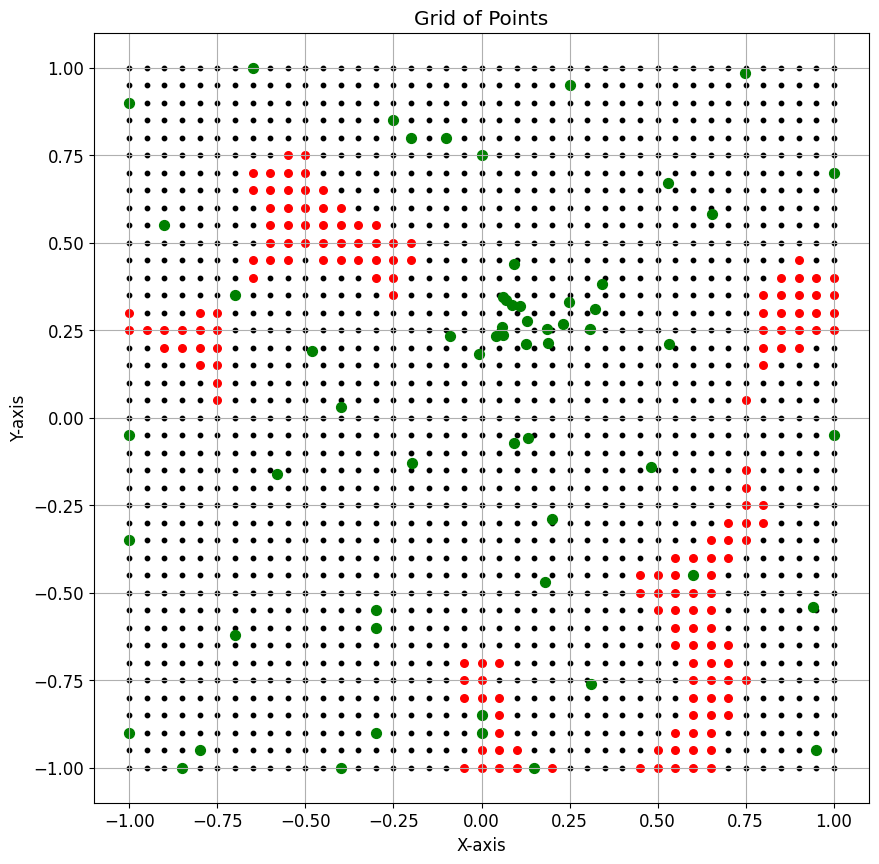

Iteration:  5
current step: 5


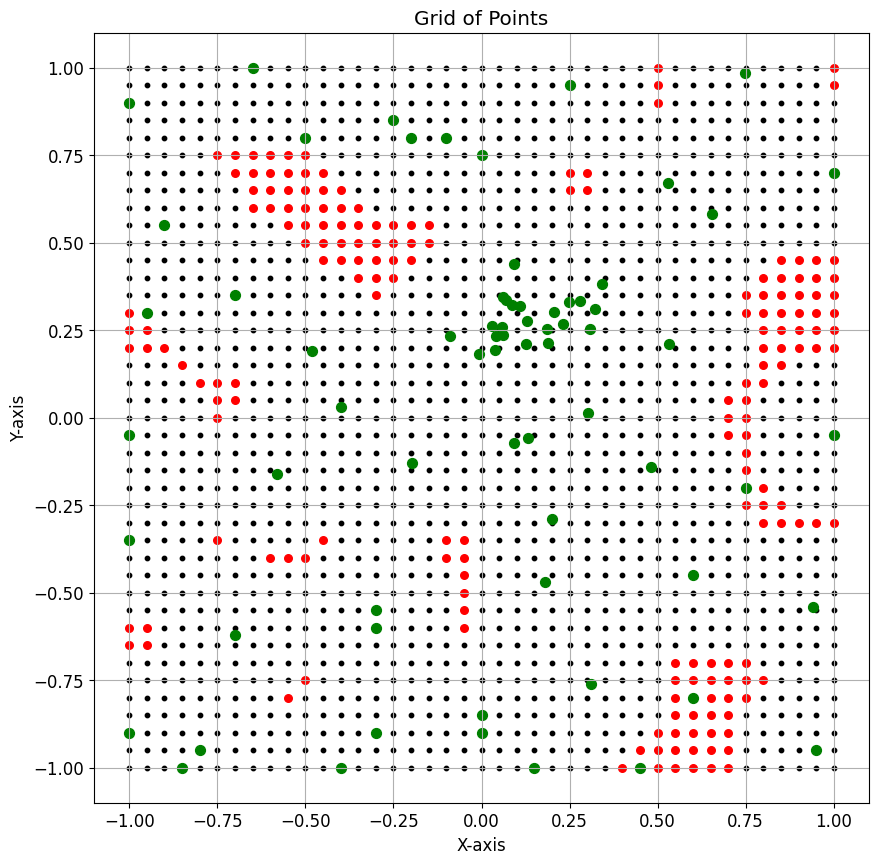

Iteration:  6
current step: 6


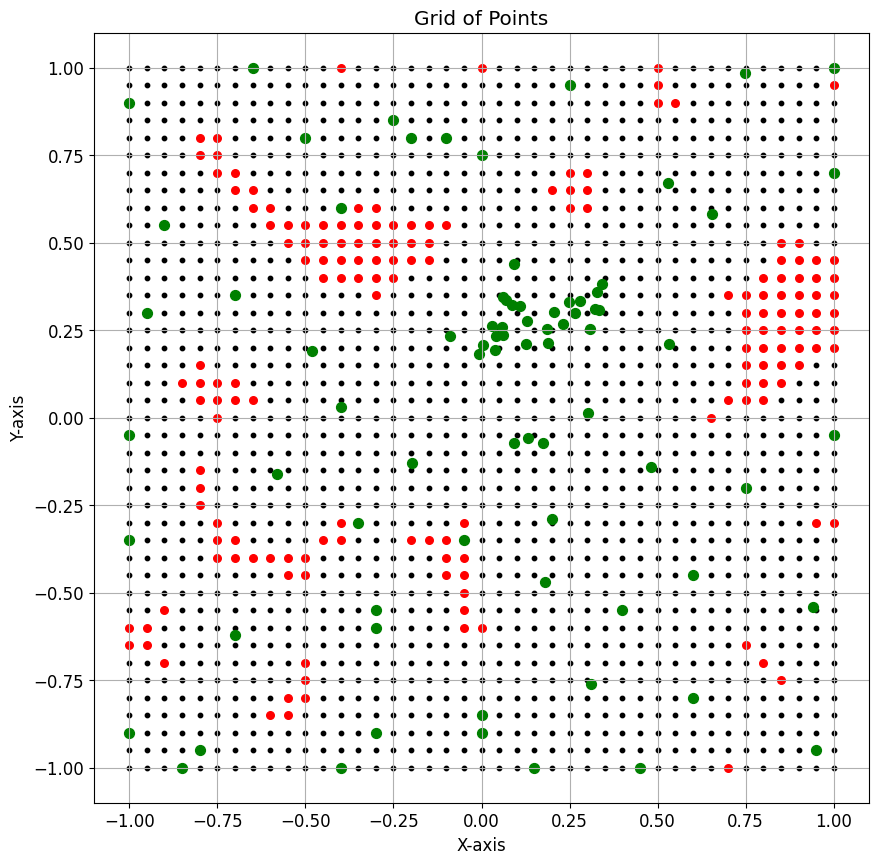

Iteration:  7
current step: 7


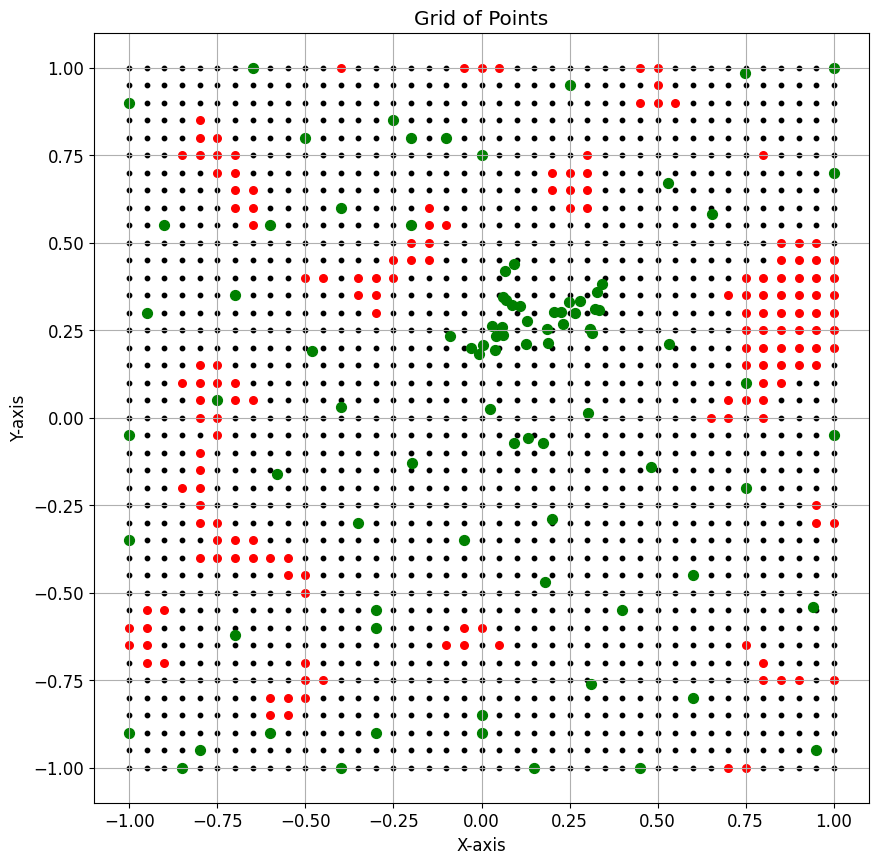

Iteration:  8
current step: 8


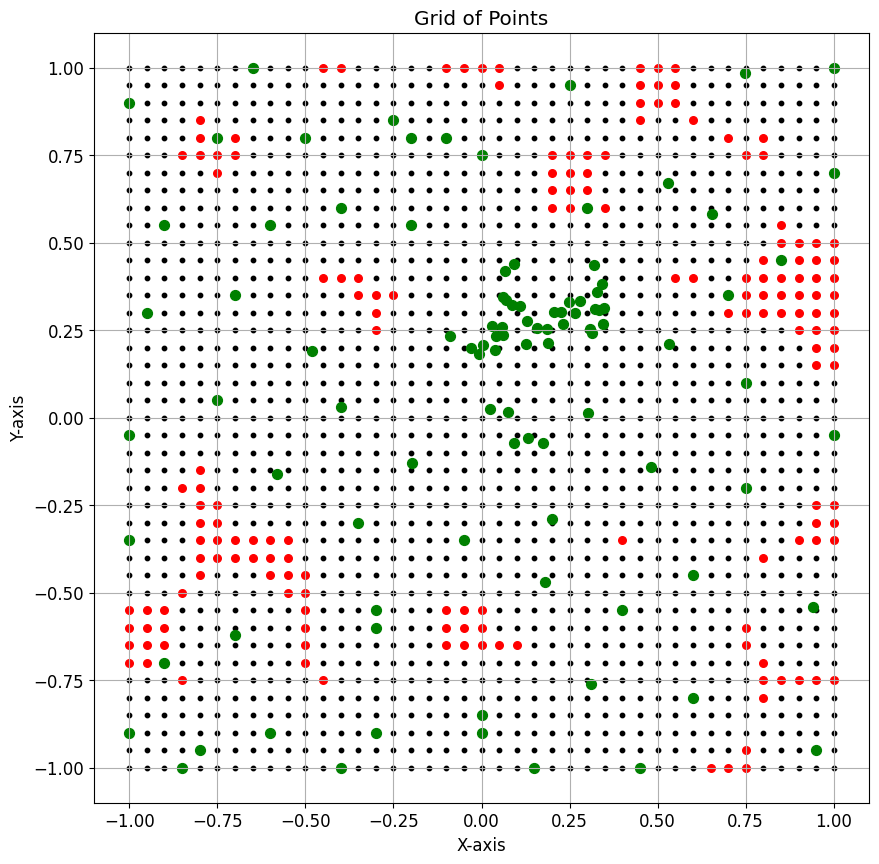

Iteration:  9
current step: 9


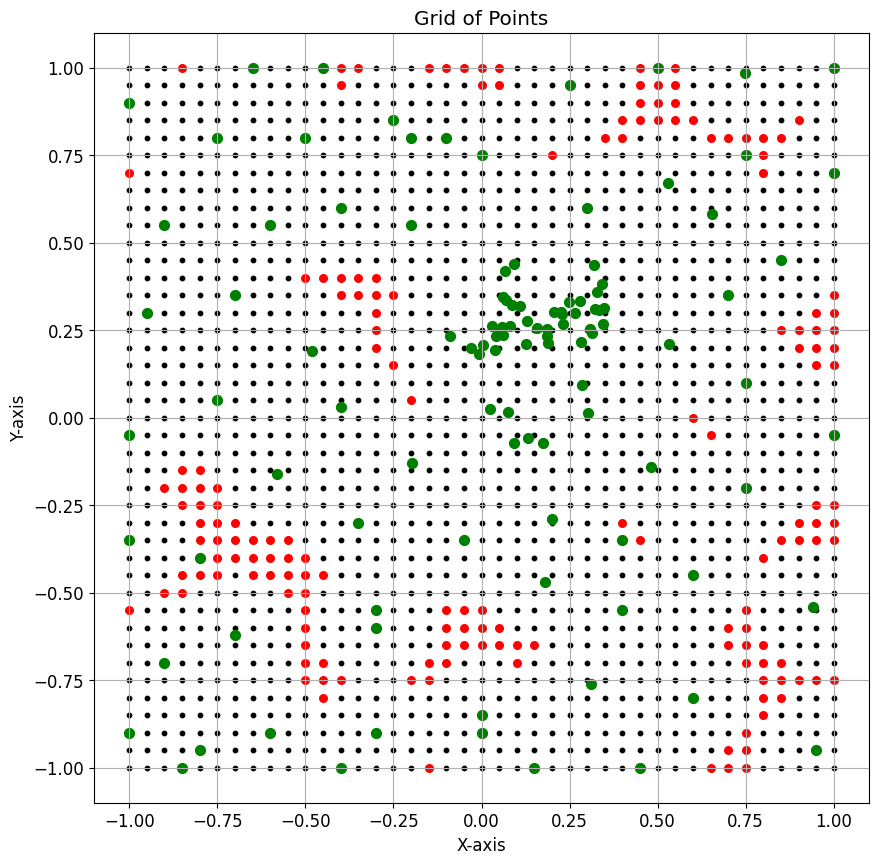

Iteration:  10
current step: 10


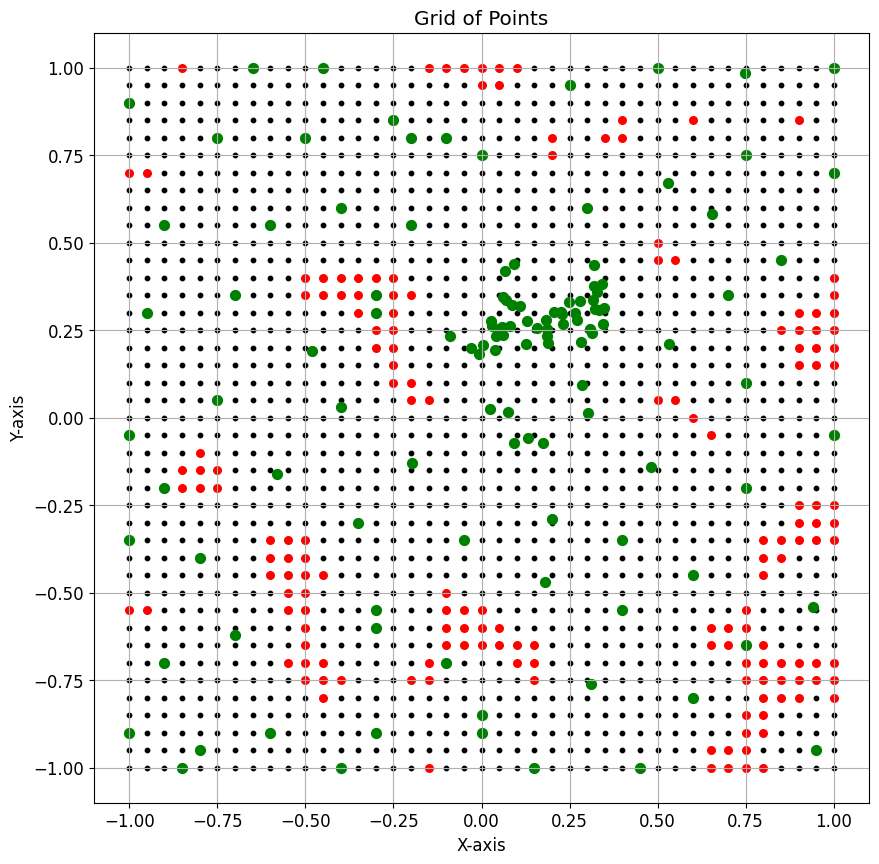

In [27]:
observation_info = env.reset()
rewards = []
std_comp = []
hig_std_comp = []
iters = 11
results_buffer = np.zeros((iters, 4))


for i in range(iters):
    print("Iteration: ", i)
    exploiters_action =  get_action(observation_info, agent_policy, env)
    explorer_action = get_informed_action(env)
    # split the agents into two groups and let one group exploit and the other explore
    actions = np.zeros((env.n_agents, env.n_dim))
    actions[:env.n_agents//2] = exploiters_action[:env.n_agents//2]
    actions[env.n_agents//2:] = explorer_action[env.n_agents//2:]
    #print(actions)
    observation_info, reward, done, info = env.step(actions)
    env.surrogate.plot_checkpoints_state()
    

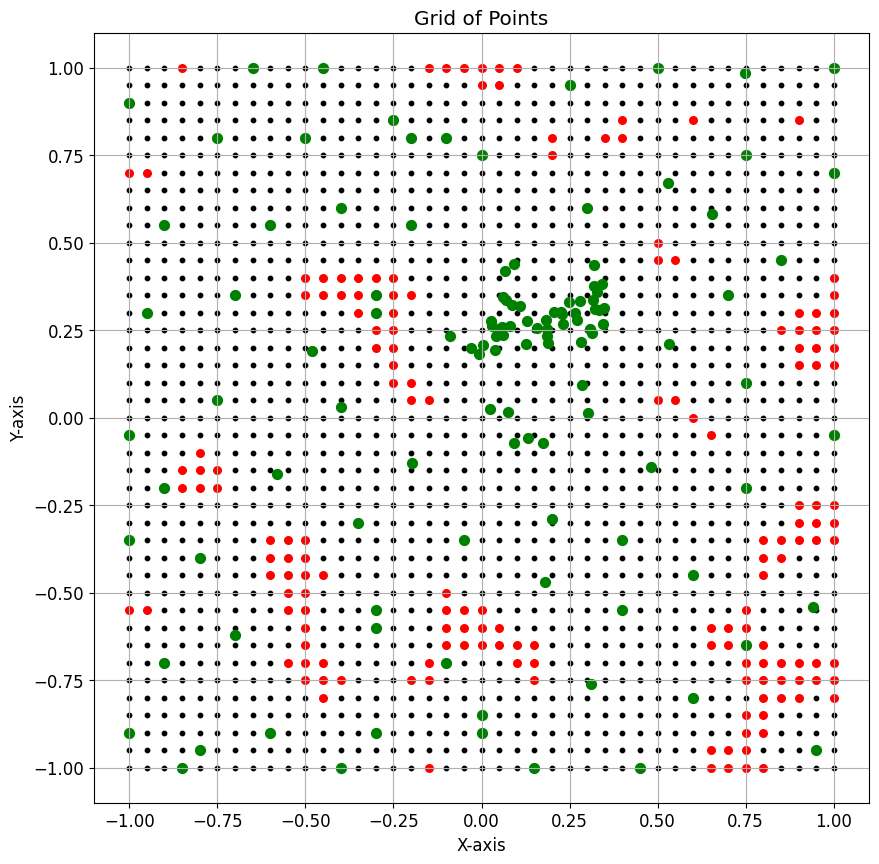

In [28]:
env.surrogate.plot_checkpoints_state()

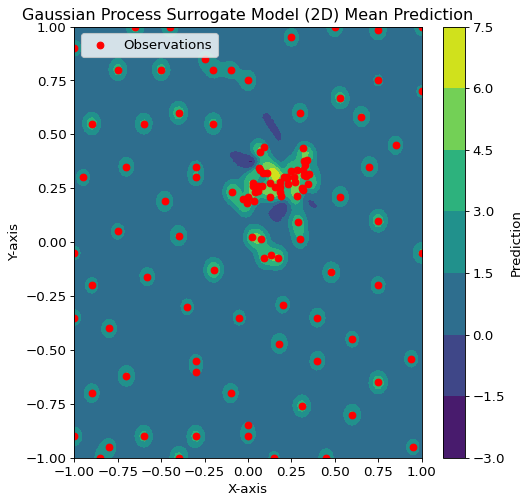

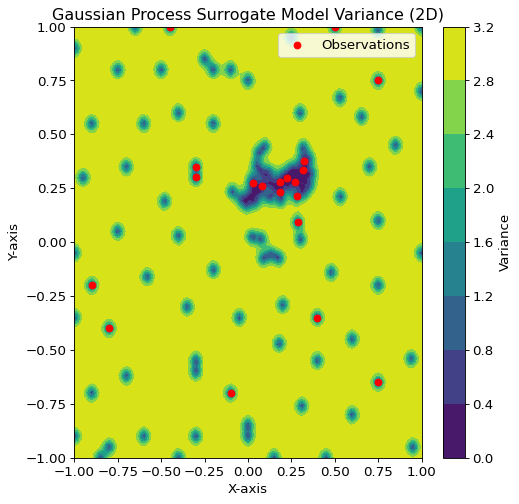

In [30]:
env.surrogate.plot_surrogate()
env.surrogate.plot_variance()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
MovieWriter Pillow unavailable; using Pillow instead.


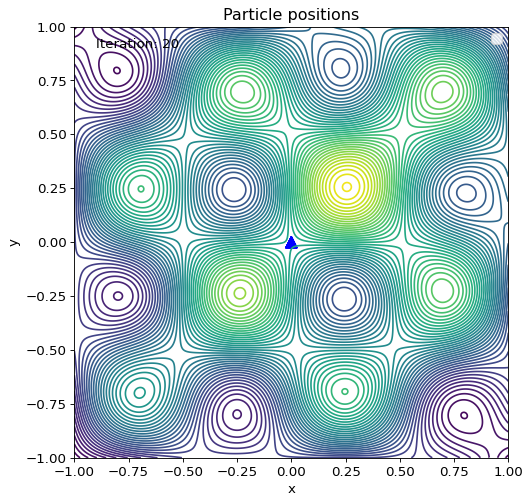

In [29]:
env.render(type="history", file_path="new_history2.gif")

Iteration:  0
current step: 0


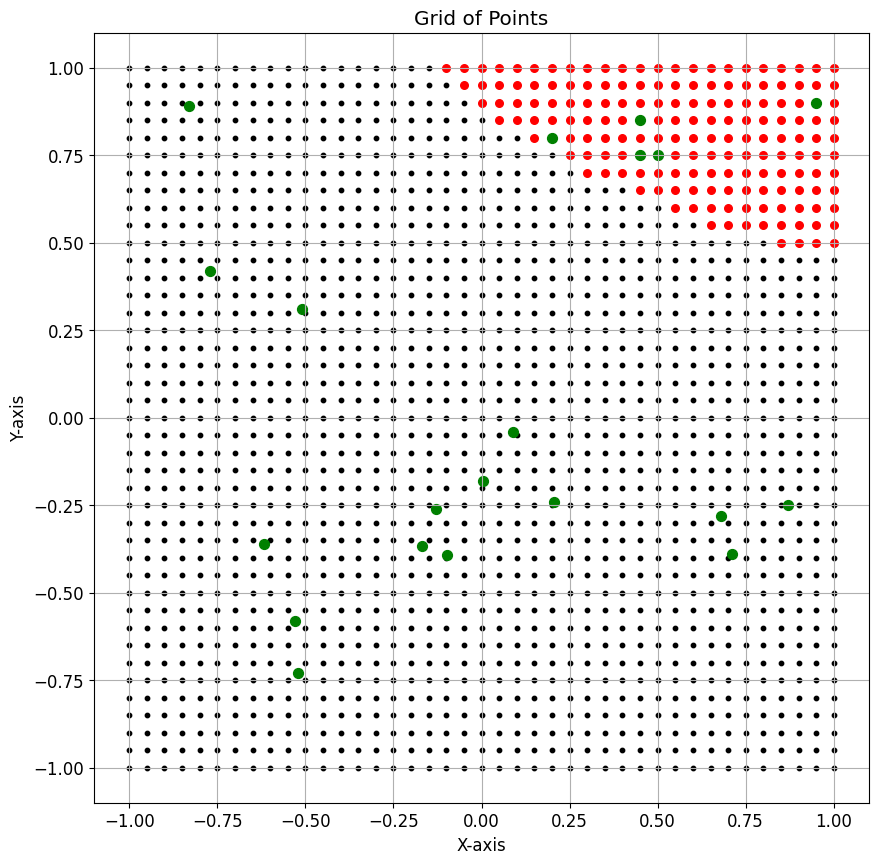

Iteration:  1
current step: 1
Iteration:  2
current step: 2
Iteration:  3
current step: 3
Iteration:  4
current step: 4


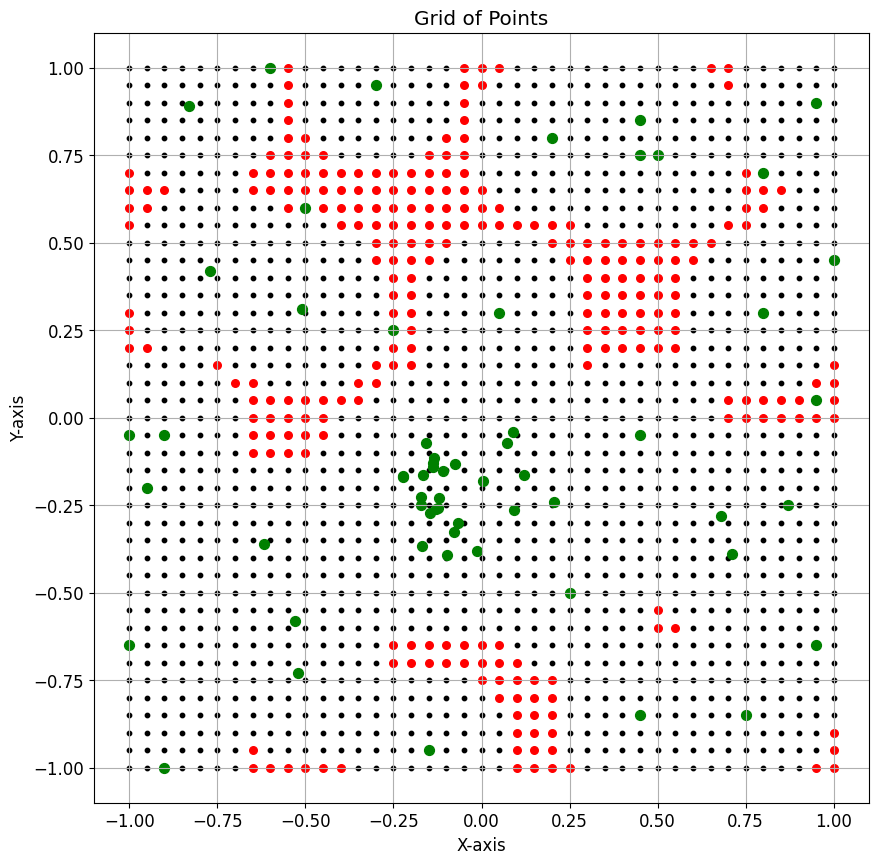

Iteration:  5
current step: 5
Iteration:  6
current step: 6
Iteration:  7
current step: 7
Iteration:  8
current step: 8


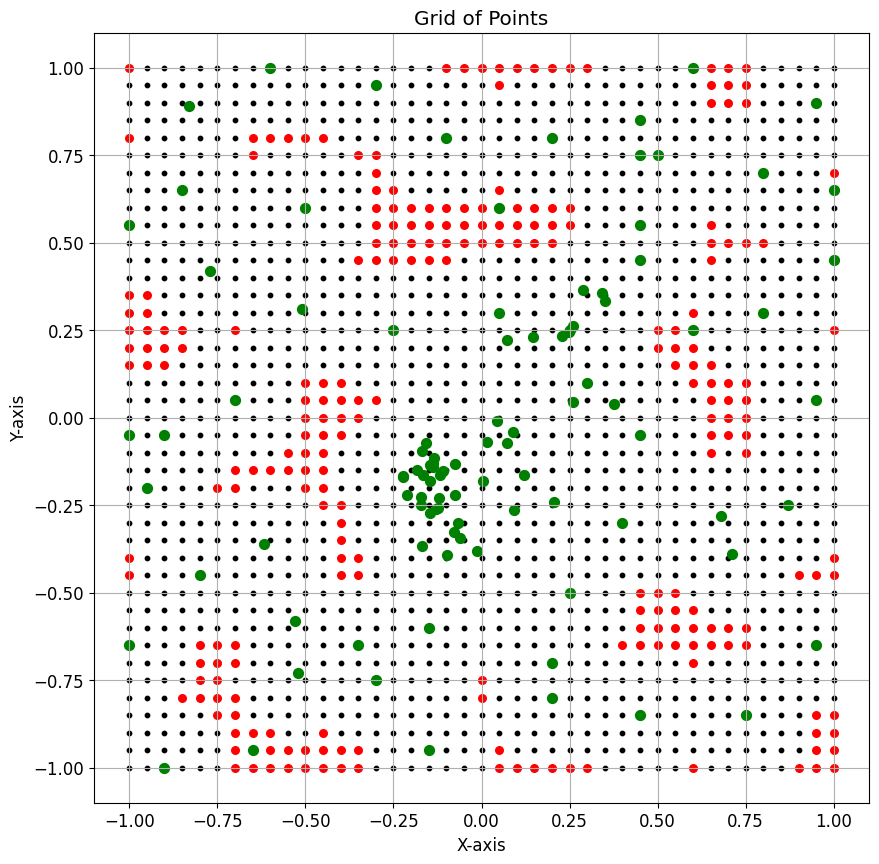

Iteration:  9
current step: 9
Iteration:  10
current step: 10
Iteration:  11
current step: 11
Iteration:  12
current step: 12


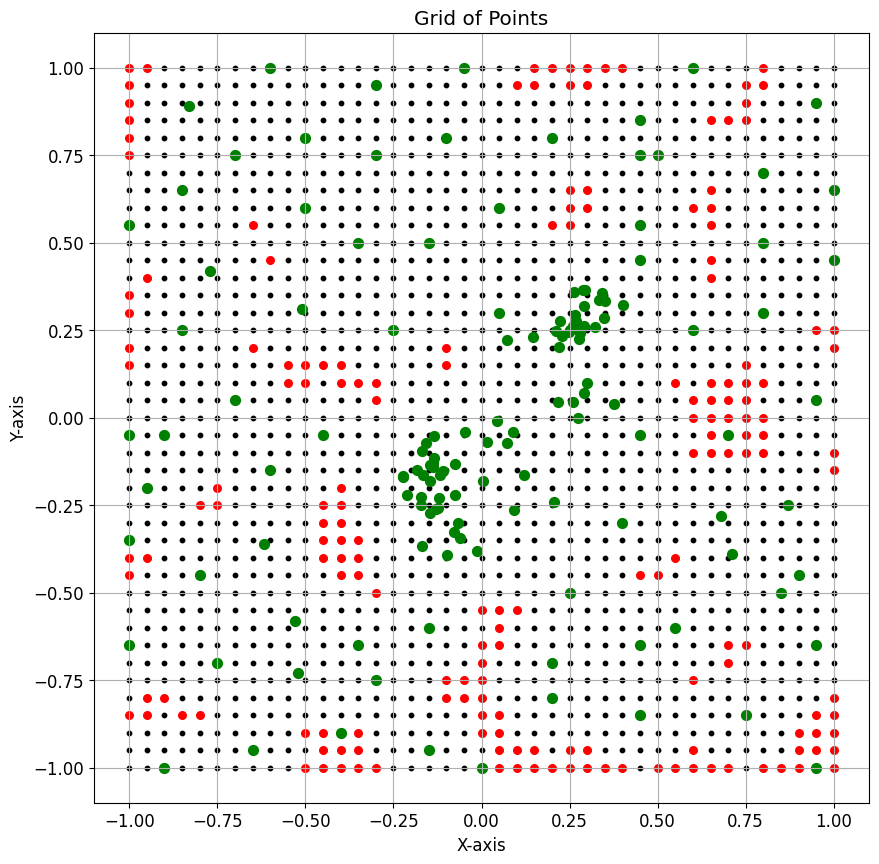

Iteration:  13
current step: 13
Iteration:  14
current step: 14
Iteration:  15
current step: 15
Iteration:  16
current step: 16


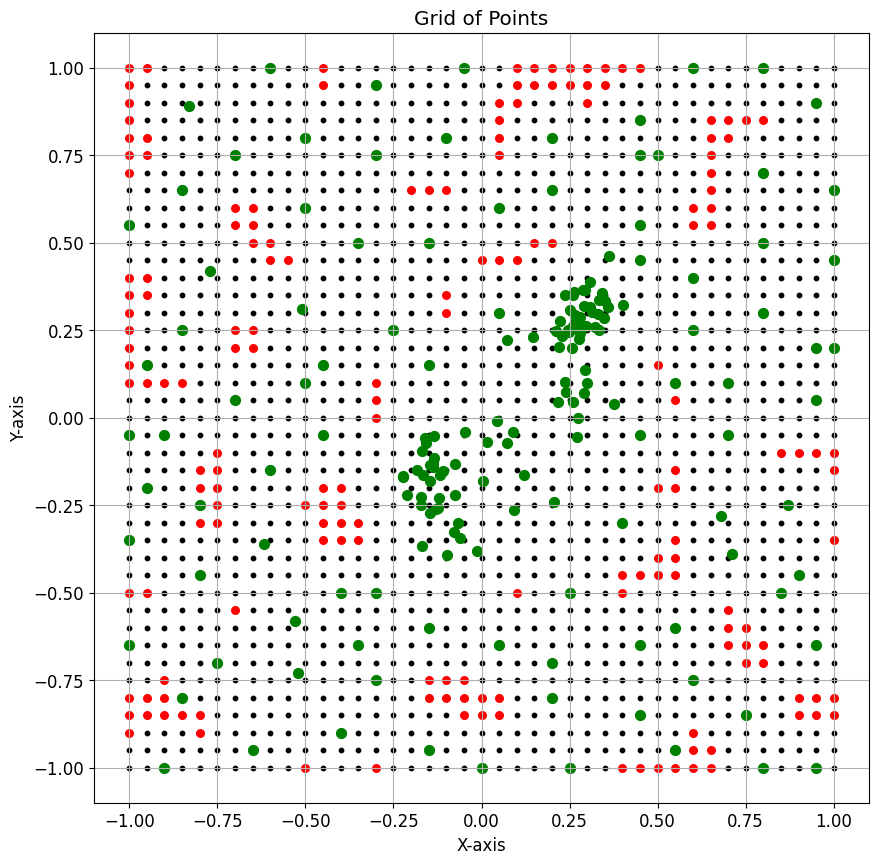

Iteration:  17
current step: 17
Iteration:  18
current step: 18
Iteration:  19
current step: 19


In [35]:
observation_info = env.reset()
rewards = []
std_comp = []
hig_std_comp = []
iters = 20
results_buffer = np.zeros((iters, 4))


for i in range(iters):
    print("Iteration: ", i)
    exploiters_action =  get_action(observation_info, agent_policy, env)
    explorer_action = get_informed_action(env)
    # split the agents into two groups and let one group exploit and the other explore
    actions = np.zeros((env.n_agents, env.n_dim))
    actions[:env.n_agents//2] = exploiters_action[:env.n_agents//2]
    actions[env.n_agents//2:] = explorer_action[env.n_agents//2:]
    #print(actions)
    observation_info, reward, done, info = env.step(actions)
    if i % 4 == 0:
        env.surrogate.plot_checkpoints_state()
    # env.surrogate.plot_checkpoints_state()
    

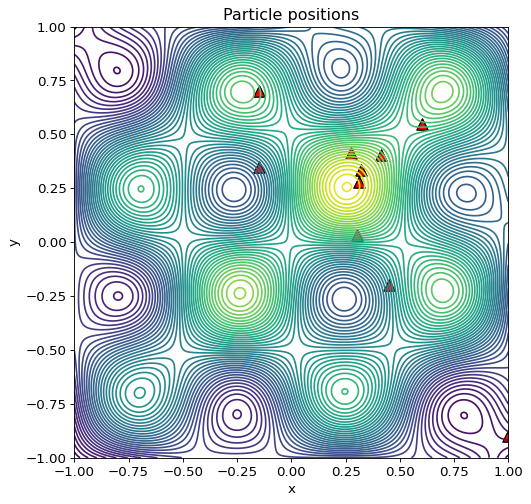

In [36]:
env.render()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
MovieWriter Pillow unavailable; using Pillow instead.


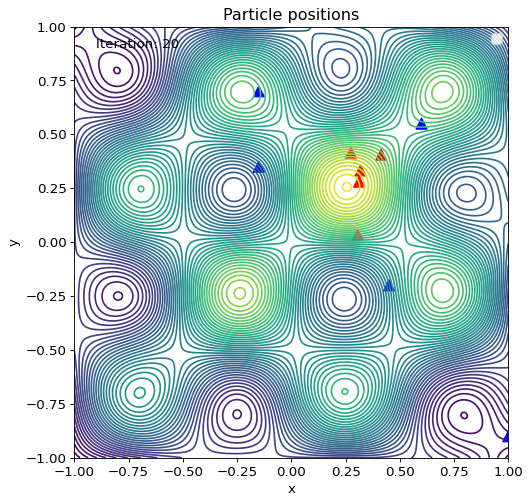

In [37]:
env.render(type="history", file_path="new_history4.gif")